# Tutorial - Creating a map and KDE plot of points and polygons with Python

## Installation

To install all needed packages within Google Colab, the following line needs to be executed (notice that libspatialindex has to be compiled, this takes a few minutes):

In [0]:
!apt-get install -qq curl g++ make

In [2]:
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  556k  100  556k    0     0  1132k      0 --:--:-- --:--:-- --:--:-- 1130k


In [3]:
%cd spatialindex-src-1.8.5

/content/spatialindex-src-1.8.5


In [4]:
!./configure; make; make install

checking build system type... x86_64-unknown-linux-gnu
checking for g++... g++
checking whether the C++ compiler works... yes
checking for C++ compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C++ compiler... yes
checking whether g++ accepts -g... yes
checking how to run the C++ preprocessor... g++ -E
checking for a BSD-compatible install... /usr/bin/install -c
checking whether ln -s works... yes
checking whether make sets $(MAKE)... yes
checking host system type... x86_64-unknown-linux-gnu
checking how to print strings... printf
checking for gcc... gcc
checking whether we are using the GNU C compiler... yes
checking whether gcc accepts -g... yes
checking for gcc option to accept ISO C89... none needed
checking whether gcc understands -c and -o together... yes
checking for a sed that does not truncate output... /bin/sed
checking fo

In [0]:
!ldconfig

In [6]:
!pip install numpy pandas geopandas matplotlib tilemapbase seaborn shapely requests rtree

     |████████████████████████████████| 921kB 3.4MB/s 
     |████████████████████████████████| 522kB 52.5MB/s 
     |████████████████████████████████| 10.1MB 45kB/s 
     |████████████████████████████████| 11.8MB 30.3MB/s 
  Created wheel for tilemapbase: filename=tilemapbase-0.4.5-cp36-none-any.whl size=25582 sha256=0691d7b6ec2920ccb62c11b1360509e4837f9e327916d88f1d659862c63f1b02
  Stored in directory: /root/.cache/pip/wheels/6a/d1/df/ec2a18c137d5c766bd331133c6db380eebacfec1c193678ed2
  Created wheel for rtree: filename=Rtree-0.9.3-cp36-none-any.whl size=21269 sha256=507f3c5ecba0a43c0650fb1bdb2ad1f50796ecbfde9cd3d1cc010eebaa55b436
  Stored in directory: /root/.cache/pip/wheels/0b/f6/58/2d819b2abdc280c3f70db0b0ce86a712839267957db7abad85
Successfully built tilemapbase rtree


In [7]:
import numpy as np 
import pandas as pd
import geopandas as gpd 
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.path import Path
from matplotlib.textpath import TextToPath
import tilemapbase
import warnings
import matplotlib.cbook
import requests

import seaborn as sns
import shapely.speedups
shapely.speedups.enable()

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


## Loading and preprocessing the data

Create a new folder, change into the folder and download the data with wget:

In [8]:
%cd /content
!mkdir amsterdam_data
%cd amsterdam_data
!wget http://download.geofabrik.de/europe/netherlands/noord-holland-latest-free.shp.zip


/content
/content/amsterdam_data
--2020-01-23 02:28:14--  http://download.geofabrik.de/europe/netherlands/noord-holland-latest-free.shp.zip
Resolving download.geofabrik.de (download.geofabrik.de)... 116.202.112.212, 88.99.142.44
Connecting to download.geofabrik.de (download.geofabrik.de)|116.202.112.212|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228991387 (218M) [application/zip]
Saving to: ‘noord-holland-latest-free.shp.zip’

noord-holland-lates 100%[===================>] 218.38M  24.5MB/s    in 9.7s    

2020-01-23 02:28:24 (22.6 MB/s) - ‘noord-holland-latest-free.shp.zip’ saved [228991387/228991387]



Unzip the files and load the points as a GeoDataFrame:

In [11]:
!unzip -j "noord-holland-latest-free.shp.zip" "gis_osm_pois_free_1.cpg" "gis_osm_pois_free_1.dbf" "gis_osm_pois_free_1.prj" "gis_osm_pois_free_1.shp" "gis_osm_pois_free_1.shx" -d "/content/amsterdam_data/"

Archive:  noord-holland-latest-free.shp.zip
 extracting: /content/amsterdam_data/gis_osm_pois_free_1.cpg  
  inflating: /content/amsterdam_data/gis_osm_pois_free_1.dbf  
  inflating: /content/amsterdam_data/gis_osm_pois_free_1.prj  
  inflating: /content/amsterdam_data/gis_osm_pois_free_1.shp  
  inflating: /content/amsterdam_data/gis_osm_pois_free_1.shx  


In [0]:
points = gpd.read_file("/content/amsterdam_data/gis_osm_pois_free_1.shp")

In [0]:
points = points.to_crs({"init": "EPSG:3857"})

Filter the data for restaurants (or any other POI category):



In [14]:
points = points[points["fclass"] == "restaurant"]
points

osm_id  code  ...                name                        geometry
92       30839687  2301  ...          de Eethoek  POINT (521775.259 6910003.671)
144      34043796  2301  ...        Sizzling Wok  POINT (550760.350 6853264.008)
146      34044093  2301  ...      De Roode Leeuw  POINT (544752.526 6867988.375)
309      94829656  2301  ...          Pata Negra  POINT (548267.528 6865590.954)
314      95288389  2301  ...               Meram  POINT (548310.876 6864750.556)
...           ...   ...  ...                 ...                             ...
36939  7124541137  2301  ...              Bregje  POINT (505775.464 6873030.827)
37025  7125482608  2301  ...              Bregje  POINT (574849.387 6850115.479)
37096  7126562153  2301  ...        Antiek China  POINT (522483.151 6928160.974)
37097  7126562155  2301  ...            Duinberk  POINT (522497.422 6928134.759)
37108  7137254485  2301  ...  Vleesch noch Visch  POINT (542280.944 6869060.363)

[2797 rows x 5 columns]

Load the shapefile for the city of Amsterdam and change the CRS to match the one of Amsterdam (needed for map tile request later):

In [15]:
r = requests.get("https://maps.amsterdam.nl/open_geodata/geojson.php?KAARTLAAG=GEBIED_STADSDELEN&THEMA=gebiedsindeling/")
city = r.text
city = gpd.read_file(city)
city = city.to_crs({"init": "EPSG:3857"})
city

Stadsdeel_code  ...                                           geometry
0              A  ...  POLYGON ((549136.599 6867376.523, 549133.148 6...
1              B  ...  POLYGON ((543892.115 6872660.218, 543540.457 6...
2              E  ...  POLYGON ((544918.815 6870710.847, 544873.285 6...
3              F  ...  POLYGON ((539955.524 6866252.019, 539951.183 6...
4              K  ...  POLYGON ((547134.629 6862225.476, 547129.731 6...
5              M  ...  POLYGON ((560946.039 6864490.649, 560918.543 6...
6              N  ...  POLYGON ((565410.507 6870704.099, 564865.041 6...
7              T  ...  POLYGON ((558996.500 6854997.221, 558987.372 6...

[8 rows x 4 columns]

Perform a spatial join between the points and polygons and filter out any points that did not match with the polygons:

In [0]:
points = gpd.sjoin(points, city, how="left")
points = points.dropna(subset=["index_right"])

plot both data sets to see if the spatial join was performed correctly

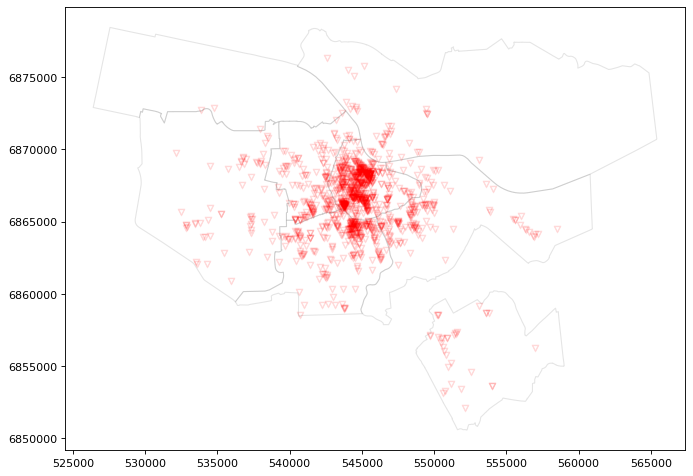

In [17]:
# edit the figure size however you need to
plt.figure(num=None, figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')
# create plot and axes
fig = plt.plot()
ax1 = plt.axes()
# these values can be changed as needed, the markers are LaTeX symbols
city.plot(ax=ax1, alpha=0.1, edgecolor="black", facecolor="white")
points.plot(ax=ax1, alpha = 0.1, color="red", marker='$\\bigtriangledown$',)
ax1.figure.savefig('/content/amsterdam_data/plot1.png', bbox_inches='tight')

## Add a background map to the plot

To get a nice background map, we need to find out all the boundaries of our data and save that for later plotting:

In [0]:
bounding_box = [points["geometry"].x.min(), points["geometry"].x.max(), points["geometry"].y.min(), points["geometry"].y.max()]

Load the background map using `tilemapbase`:

In [0]:
tilemapbase.start_logging()
tilemapbase.init(create=True)
extent = tilemapbase.extent_from_frame(city, buffer = 25)

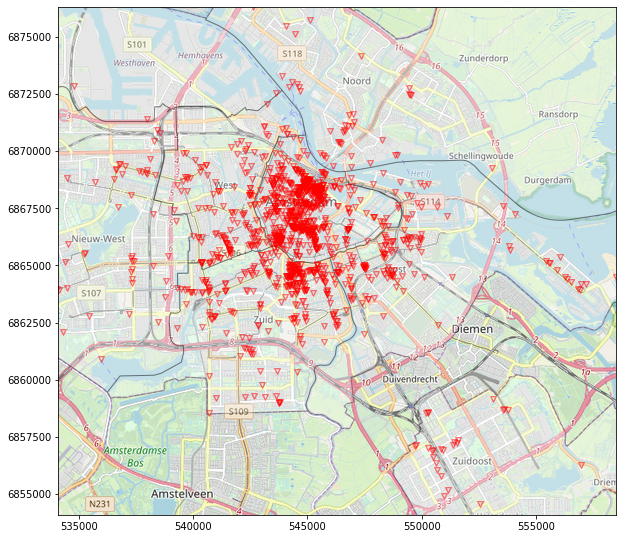

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=1000)
plotter.plot(ax)
ax.set_xlim(bounding_box[0]+2000, bounding_box[1])
ax.set_ylim(bounding_box[2]+2000, bounding_box[3])
city.plot(ax=ax, alpha=0.3, edgecolor="black", facecolor="white")
points.plot(ax=ax, alpha = 0.4, color="red", marker='$\\bigtriangledown$',)
ax.figure.savefig('/content/amsterdam_data/plot2.png', bbox_inches='tight')

## Show a KDE plot of the spatial distribution

To get an impression on the spatial distribution, a KDE plot might help. For this we use the `kdeplot`-function from seaborn.

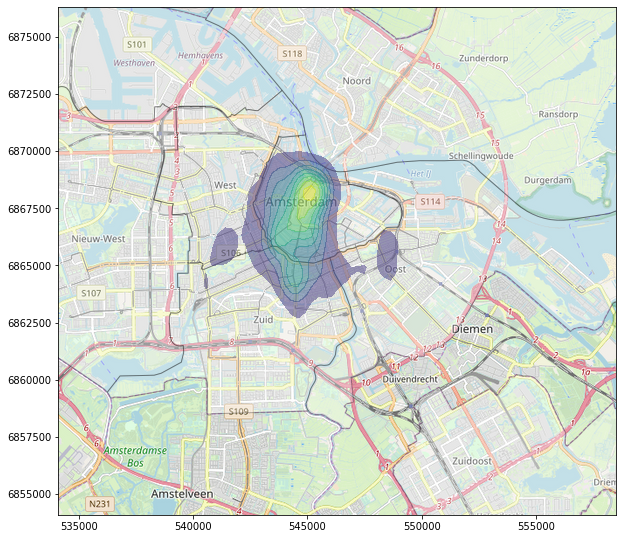

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=1000)
plotter.plot(ax)
ax.set_xlim(bounding_box[0]+2000, bounding_box[1])
ax.set_ylim(bounding_box[2]+2000, bounding_box[3])
city.plot(ax=ax, alpha=0.3, edgecolor="black", facecolor="white")
sns.kdeplot(points["geometry"].x, points["geometry"].y, shade=True, alpha=0.5, cmap="viridis", shade_lowest=False)
ax.figure.savefig('/content/amsterdam_data/plot3.png', bbox_inches='tight')

## Color the markers with the KDE information

Instead of drawing the KDE as a single shape, we can also color our points according to the density. For this we calculate the gaussian KDE separately and use the result as z-values for our plot. The markers can be changed to ones liking, for this case I settled with simple points:

In [0]:
xy = np.vstack([points["geometry"].x,points["geometry"].y])
z = gaussian_kde(xy)(xy)

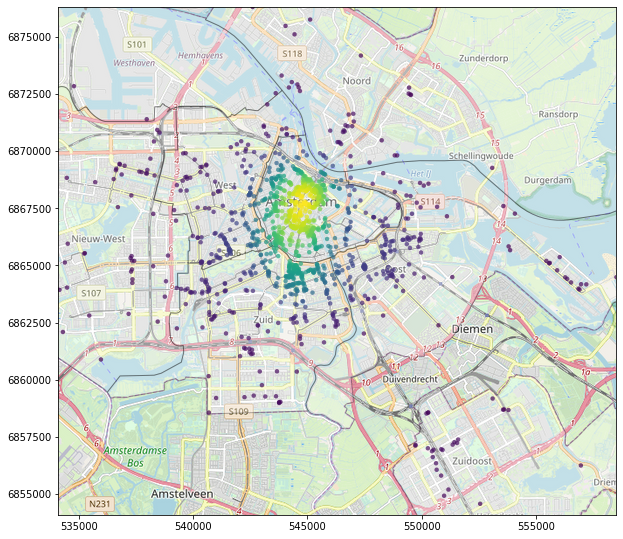

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=1000)
plotter.plot(ax)
ax.set_xlim(bounding_box[0]+2000, bounding_box[1])
ax.set_ylim(bounding_box[2]+2000, bounding_box[3])
city.plot(ax=ax, alpha=0.3, edgecolor="black", facecolor="white")
ax.scatter(points["geometry"].x, points["geometry"].y, c=z, s=20, zorder=2, edgecolor='',  alpha=0.7)
ax.figure.savefig('/content/amsterdam_data/plot4.png', bbox_inches='tight')

## Use more specific symbols as map markers

If you want to change the markers in the map to more sophisticated ones, you could also use Font Awesome. Download the font from here and save it to `/resources/`. Edit the `symbols` dict to add symbols that might fit your subject, a cheat sheet for the unicode characters can be found on [the fontawesome website](https://fontawesome.com/cheatsheet). Just add a `\u` to any of the unicode characters.

In [24]:
!wget https://github.com/FortAwesome/Font-Awesome/blob/master/otfs/Font%20Awesome%205%20Free-Solid-900.otf?raw=true

--2020-01-23 02:30:21--  https://github.com/FortAwesome/Font-Awesome/blob/master/otfs/Font%20Awesome%205%20Free-Solid-900.otf?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/FortAwesome/Font-Awesome/raw/master/otfs/Font%20Awesome%205%20Free-Solid-900.otf [following]
--2020-01-23 02:30:21--  https://github.com/FortAwesome/Font-Awesome/raw/master/otfs/Font%20Awesome%205%20Free-Solid-900.otf
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FortAwesome/Font-Awesome/master/otfs/Font%20Awesome%205%20Free-Solid-900.otf [following]
--2020-01-23 02:30:22--  https://raw.githubusercontent.com/FortAwesome/Font-Awesome/master/otfs/Font%20Awesome%205%20Free-Solid-900.otf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 

In [0]:
fp = FontProperties(fname=r"/content/amsterdam_data/Font Awesome 5 Free-Solid-900.otf?raw=true") 

def get_marker(symbol):
    v, codes = TextToPath().get_text_path(fp, symbol)
    v = np.array(v)
    mean = np.mean([np.max(v,axis=0), np.min(v, axis=0)], axis=0)
    return Path(v-mean, codes, closed=False)

symbols = dict(map = "\uf041", map_alt = "\uf3c5")

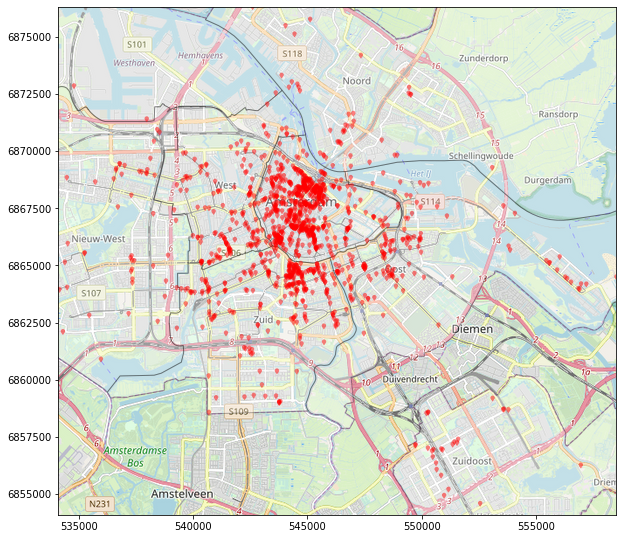

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=1000)
plotter.plot(ax)
ax.set_xlim(bounding_box[0]+2000, bounding_box[1])
ax.set_ylim(bounding_box[2]+2000, bounding_box[3])
city.plot(ax=ax, alpha=0.3, edgecolor="black", facecolor="white")
ax.scatter(points["geometry"].x, points["geometry"].y, c="red", s=35, zorder=2, edgecolor='',  alpha=0.5, marker=get_marker(symbols["map"]))
ax.figure.savefig('/content/amsterdam_data/plot5.png', bbox_inches='tight')

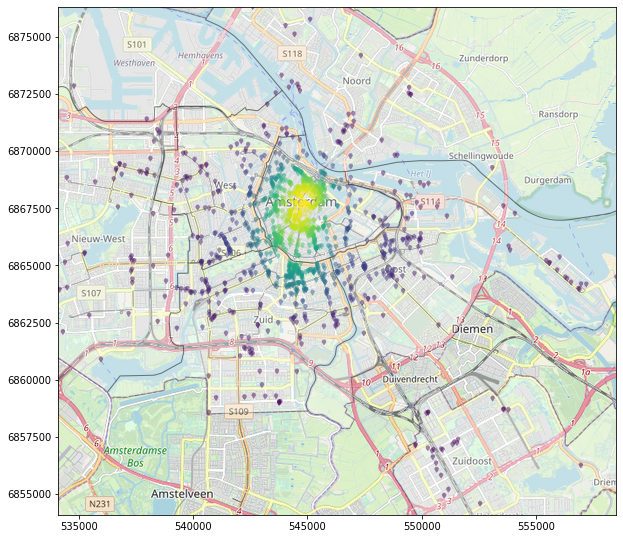

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=1000)
plotter.plot(ax)
ax.set_xlim(bounding_box[0]+2000, bounding_box[1])
ax.set_ylim(bounding_box[2]+2000, bounding_box[3])
city.plot(ax=ax, alpha=0.3, edgecolor="black", facecolor="white")
ax.scatter(points["geometry"].x, points["geometry"].y, c=z, s=35, zorder=2, edgecolor='',  alpha=0.5, marker=get_marker(symbols["map"]))
ax.figure.savefig('/content/amsterdam_data/plot6.png', bbox_inches='tight')